# Loading in the data

In [128]:
#!/usr/bin/env python

import numpy as np
import ase.db
import jax
import jax.numpy as jnp
import tqdm.auto

DB_FILE_NAME = "data/SrTiO3_500.db"
# This is the element-to-type map used for generating the descriptors, which
# determines the order of the descriptor vector for each atom.
SORTED_ELEMENTS = sorted(["Sr", "Ti", "O"])
SYMBOL_MAP = {s: i for i, s in enumerate(SORTED_ELEMENTS)}

# 65 Oxygen atoms
# 15 Strontium atoms
# 25 Titanium atoms
type_to_AN_dict = {
    0: 8,
    1: 38,
    2: 22
}

type_to_charges_dict = {
    0: np.float64(-1.15),
    1: np.float64(1.83),
    2: np.float64(1.892)
}

# These labels identify each individual configuration in the larger
# database this small subsample was extracted from.
ind_labels = []
# Atom type, from 0 to n_types - 1.
types = []
# In case we want to use them for the electron-passing NN.
atomic_numbers = []
# Positions of each atom in each configuration, in Cartesian coordinates
# expressed in Å.
positions = []
# There are periodic boundary conditions in effect along the X and Y 
# directions. The length of the simulation box along those directions
# is stored in the elements [0, 0] and [1, 1] of the 3x3 matrices
# stored in this array. Although there is a cell matrix for each
# configuration, they are all the same in this case. The units are also
# Å. The [2, 2] element is immaterial, and the rest are zero.
cell_lengths = []
# Spherical Bessel descriptors for each atom, generated using the following
# parameters:
# N_MAX = 5
# R_CUT = 5.5
descriptors = []
# DDEC6 charges that we will try to predict,
charges = []

cell_size = np.array([])

with ase.db.connect(DB_FILE_NAME) as db:
    for idx, row in enumerate(tqdm.auto.tqdm(db.select(), total=db.count())):
        ind_labels.append(row["ind_label"])
        descriptors.append(row["data"]["bessel_descriptors"])
        charges.append(row["data"]["ddec6_charges"])

        atoms = row.toatoms()
        symbols = atoms.get_chemical_symbols()
        types.append([SYMBOL_MAP[s] for s in symbols])
        atomic_numbers.append(atoms.get_atomic_numbers())
        positions.append(atoms.get_positions())
        cell_lengths.append(atoms.cell.lengths())
        cell_size = atoms.cell

            

# def get_cell_lengths(cell):
#     return jnp.array(cell.lengths())

# v_get_cell_lengths = jnp.vectorize(get_cell_lengths)

descriptors = jnp.asarray(descriptors)
charges = jnp.asarray(charges)
types = jnp.asarray(types)
atomic_numbers = jnp.asarray(atomic_numbers)
positions = jnp.asarray(positions)
# Check if all cell sizes are the same!
# If they are not, we need to use the correct ones for each distance calculation
cell_size = np.array(cell_size)
# Run this as cell size of z-axis is irrelevant
cell_size[2,2]=0.0
cell_size = jnp.array(cell_size)
cell_lengths = jnp.array(cell_lengths)
cell_size

# if np.array([cells[i]==cells[0] for i in range(len(cells))]).flatten().all():
#     cell_size = cells[0]

  0%|          | 0/500 [00:00<?, ?it/s]

DeviceArray([[ 5.5792565,  0.       ,  0.       ],
             [ 0.       , 11.83539  ,  0.       ],
             [ 0.       ,  0.       ,  0.       ]], dtype=float32)

### Cell Size
The cell size is the size of the elemental cell in three dimensions

In [51]:
cell_lengths.shape

(500, 3)

### Bessel descriptors 

The Bessel descriptors describe the dynamics of the system with a 6x21 array for each atom in the slab. The first dimension describes the complete set of possible element-element pairs. The second axis describes angular and radial indices.

Can be treated as black box.

In [52]:
descriptors.shape

(500, 105, 6, 21)

### Charges

The charges are the target values to predict.

In [4]:
charges.shape

(500, 105)

The types describe the elements as categorical integers. The atomic numbers are described by their name. 

In [54]:
types[0]
atomic_numbers[0]
type_to_AN_dict = {
    0: 8,
    1: 38,
    2: 22
}

Positions are 3-dimensional arrays for each atom that describe their position.

In [55]:
positions.shape

(500, 105, 3)

In [56]:
coordinates = positions[0]

# Batch distance calculations with single dimensions

In [67]:
def calculate_xy_distance(v1: jnp.float32, v2: jnp.float32, cell_length: jnp.float32) -> jnp.float32:
    ''' Calculates the the distance of two values over the x- and y-axis with respect to periodic boundary conditions.
    Input:
        - v1: jnp.float32 - x- or y-value of first atom
        - v2: jnp.float32 - x- or y-value of second atom
        - cell_length: jnp.float32 - length of the elemental cell in the respective dimension
    Output:
        - distance in respective dimension
    '''
    delta = v1-v2
    delta = jnp.abs(delta - cell_length*jnp.round(delta/cell_length,0))
    return delta

v_calculate_xy_distance = jnp.vectorize(calculate_xy_distance, excluded = [2])

def calculate_distances(pos1: jnp.array, positions: jnp.array, cell_size: jnp.array):
    ''' Calculates the the distance of two atom-positions in the 3D-space of the slab.
    Input:
        - pos1: jnp.array -> position of first atom
        - pos2: jnp.array -> position of second atom
        - cell_size: jnp.array -> size of elemental cell
    Output:
        - euclidean distance with respect to periodic boundary conditions
    '''
    assert pos1.shape == (3,) and positions.shape == (105,3) and cell_size.shape == (3,)
    x_distances = v_calculate_xy_distance(positions[:,0],pos1[0],cell_size[0])
    y_distances = v_calculate_xy_distance(positions[:,1],pos1[1],cell_size[1])
    z_distances = positions[:,2]-pos1[2]
    euclidean_distances = jnp.sqrt(x_distances**2 + y_distances**2 + z_distances**2)
    return euclidean_distances

@jax.jit
def v_calculate_distances(positions: jnp.array, cell_lengths: jnp.array):
    ''' Calculates the the pairwise distances of all atom-positions in the 3D-space of the slab.
    Input:
        - positions: jnp.array -> positions of all atoms 
        - cell_lengths: jnp.array -> cell lengths repeated to fit batch size
    Output:
        - pairwise euclidean distances with respect to periodic boundary conditions for all atoms in this batch
    '''
    vmapped_func = jax.vmap(calculate_distances)
    positions_rep = jnp.repeat(positions[np.newaxis,:,:],105, axis=0)
    cell_lengths_rep = jnp.repeat(jnp.array(cell_lengths)[jnp.newaxis,:],105, axis=0)
    return vmapped_func(positions,positions_rep,cell_lengths_rep)

@jax.jit
def batch_calculate_distances(batch_positions: jnp.array, batch_cell_lengths: jnp.array):
    ''' Calculates the pairwise distance of atoms in the 3D-space of the slab vectorized for a batch.
    Input:
        - batch_positions: jnp.array -> batch of positions of all atoms 
        - batch_cell_lengths: jnp.array -> batch of cell lengths of second atom
    Output:
        - pairwise euclidean distances with respect to periodic boundary conditions for all atoms in all batches
    '''
    batch_v_calculate_distances = jax.vmap(v_calculate_distances)
    batch_distances = batch_v_calculate_distances(batch_positions, batch_cell_lengths)
    return batch_distances

test_primitive = batch_calculate_distances(positions, cell_lengths)

# Batch distance calculations with jnp.einsum

In [68]:
from functools import partial
@partial(jax.jit, static_argnums=(1,))
def jit_linalg(input, axis):
    return jnp.linalg.norm(input, axis=axis)

@jax.jit
def center_at_atoms(coordinates: jnp.ndarray, cell_size: jnp.ndarray):
    delta = coordinates - coordinates[:, jnp.newaxis, :]
    delta -= jnp.einsum(
        "ijk,kl",
        jnp.round(jnp.einsum("ijk,kl", delta, jnp.linalg.pinv(cell_size))),
        cell_size
    )    
    return jit_linalg(delta,2)

def center_at_atoms_diagonal(coordinates: jnp.ndarray, cell_size_diagonal: jnp.ndarray):
    delta = coordinates - coordinates[:, jnp.newaxis, :]
    zero_indices = cell_size_diagonal == 0.
    icell_size_diagonal = jnp.where(zero_indices, 0., 1. / jnp.where(zero_indices, 1., cell_size_diagonal))
    delta -= cell_size_diagonal * jnp.round(delta * icell_size_diagonal)
    return jnp.sqrt(jnp.sum(delta**2, axis=-1))

v_center_at_atoms_diagonal = jax.jit(jax.vmap(center_at_atoms_diagonal))


# Vectorized version with vmap
v_center_at_atoms = jax.jit(jax.vmap(center_at_atoms))
cell_size_rep = jnp.repeat(jnp.array(cell_size)[jnp.newaxis,:],500, axis=0)
cell_size_diag_rep = jnp.repeat(jnp.diag(cell_size)[jnp.newaxis,:],500, axis=0)
test_einsum = v_center_at_atoms(positions,cell_size_rep)
test_diag_center = v_center_at_atoms_diagonal(positions,jnp.repeat(jnp.diag(cell_size)[jnp.newaxis,:],500, axis=0))

In [59]:
%timeit test_einsum = v_center_at_atoms(positions,cell_size_rep)

9.68 ms ± 79.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [60]:
%timeit test_diag_center = v_center_at_atoms_diagonal(positions,cell_size_diag_rep)

136 µs ± 4.69 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [61]:
%timeit test_primitive = batch_calculate_distances(positions, cell_lengths)

142 µs ± 4.13 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [265]:
print((test_einsum == test_primitive).all())
print((test_diag_center == test_primitive).all())
print((test_einsum == test_diag_center).all())

True
True
True


# Smooth Cutoff

[1.0000000e+00 1.0000000e+00 1.0000000e+00 ... 0.0000000e+00 5.9604645e-08
 0.0000000e+00]


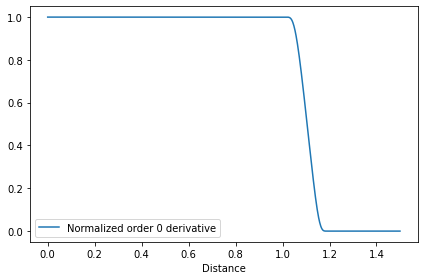

In [260]:
import jax
import jax.numpy as jnp
import functools
import matplotlib
import matplotlib.pyplot as plt

def _aux_function_f(t):
    "First auxiliary function used in the definition of the smooth bump."
    return jnp.where(t > 0., jnp.exp(-1. / jnp.where(t > 0., t, 1.)), 0.)


def _aux_function_g(t):
    "Second auxiliary function used in the definition of the smooth bump."
    f_of_t = _aux_function_f(t)
    return f_of_t / (f_of_t + _aux_function_f(1. - t))


def smooth_cutoff(r, r_switch, r_cut):
    """One-dimensional smooth cutoff function based on a smooth bump.

    This function follows the prescription given by Loring W. Tu in
    "An Introduction to Manifolds", 2nd Edition, Springer

    Args:
        r: The radii at which the function must be evaluated.
        r_switch: The radius at which the function starts differing from 1.
        r_cut: The radius at which the function becomes exactly 0.
    """
    r_switch2 = r_switch * r_switch
    r_cut2 = r_cut * r_cut

    return 1. - _aux_function_g((r * r - r_switch2) / (r_cut2 - r_switch2))





R_SWITCH = 1.0
R_CUT = 1.2
N_DERIVATIVES = 3

test_cutoff = functools.partial(smooth_cutoff,
                                r_switch=R_SWITCH,
                                r_cut=R_CUT)

distance = jnp.linspace(0., 1.5, num=1001)
to_plot = test_cutoff
for order in range(N_DERIVATIVES + 1):
    samples = jax.jit(jax.vmap(to_plot))(distance)
    print(samples)
    samples /= jnp.fabs(samples).max()
    plt.plot(distance, samples, label=f"Normalized order {order} derivative")
    break
    to_plot = jax.grad(to_plot)

plt.xlabel("Distance")
plt.legend(loc="best")
plt.tight_layout()
plt.show()

In [272]:
batched_distances = test_diag_center
import importlib
importlib.reload(preprocessing)
x = preprocessing.get_gaussian_distance_encodings(batched_distances)

Mu-Shape (500, 105, 105, 48)
BD-Shape (500, 105, 105, 48)
e-enc shape (500, 105, 105, 48)


# Cutoff from EPNN Github

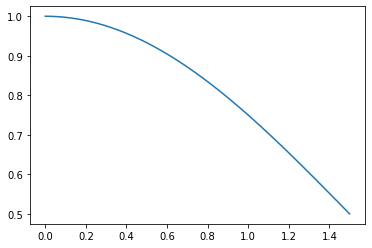

In [275]:
cutoff = 3.0
distance = np.array(distance)
C = (np.cos(np.pi * (distance - 0.0) / cutoff) + 1.0) / 2.0
C[distance >= cutoff] = 0.0
C[distance <= 0.0] = 1.0
plt.plot(distance, C)
plt.show()

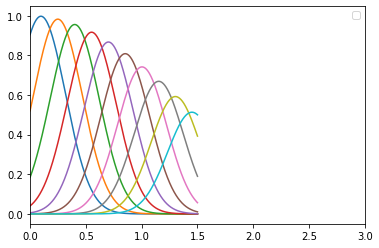

In [286]:
eta= 10
mus = np.linspace(0.1,1.5, 10)
for mu in mus:
    y = C*np.exp(-eta * (distance-mu)**2)
    plt.plot(distance, y)
plt.legend()
plt.xlim((0,3))
plt.show()

# Our cutoff

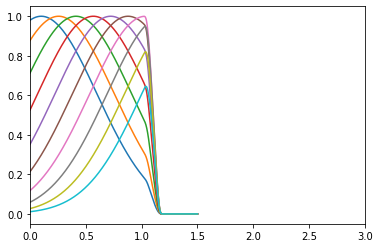

In [264]:
mus = np.linspace(0.1,1.5, 10)
for mu in mus:
    y = jax.jit(jax.vmap(test_cutoff))(distance)*np.exp(-2.0 * (distance-mu)**2)
    plt.plot(distance, y)
plt.xlim((0,3))
plt.show()

In [213]:
import importlib
importlib.reload(preprocessing)
preprocessing.get_init_charges(types,
                                "specific",
                                type_to_charges_dict,
                                jnp.zeros(500))
preprocessing.get_init_charges(types,
                                "average",
                                type_to_charges_dict,
                                jnp.zeros(500))

DeviceArray([[0., 0., 0., ..., 0., 0., 0.],
             [0., 0., 0., ..., 0., 0., 0.],
             [0., 0., 0., ..., 0., 0., 0.],
             ...,
             [0., 0., 0., ..., 0., 0., 0.],
             [0., 0., 0., ..., 0., 0., 0.],
             [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

### Transpose operations as examples

In [306]:
# 2 atoms
A = np.array([
    [1,2,3],
    [4,5,6]
    ])
A = np.tile(np.expand_dims(A,1),(1,2,1))
A

array([[[1, 2, 3],
        [1, 2, 3]],

       [[4, 5, 6],
        [4, 5, 6]]])

In [299]:
A_t = A.transpose(1,0,2)
A_t

array([[[1, 2, 3],
        [4, 5, 6]],

       [[1, 2, 3],
        [4, 5, 6]]])

In [303]:
A_r = np.reshape(A, [-1, A.shape[-1]])
A_t_r = np.reshape(A_t, [-1, A_t.shape[-1]])
print(A_r)
A_t_r

[[1 2 3]
 [1 2 3]
 [4 5 6]
 [4 5 6]]


array([[1, 2, 3],
       [4, 5, 6],
       [1, 2, 3],
       [4, 5, 6]])

In [308]:
np.reshape(A_r, [-1, 2, 2, 3])

(1, 2, 2, 3)